<a href="https://colab.research.google.com/github/aryamanpandya99/diffusers/blob/image_latent_prior_based_diffusion/Image_latents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instead of starting with random noise, let's start with a different image and see what the generation/diffusion process looks like

In [85]:
!pip install -Uq diffusers transformers fastcore

In [86]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from tqdm.auto import tqdm
from diffusers import StableDiffusionPipeline
from fastcore.all import concat
from huggingface_hub import notebook_login
from PIL import Image

logging.disable(logging.WARNING)

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

In [87]:
pipe = StableDiffusionPipeline.from_pretrained("Stabilityai/stable-diffusion-2", variant="fp16", torch_dtype=torch.float16)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [88]:
from transformers import CLIPTextModel, CLIPTokenizer

Setting Up Diffusion Components:
- Tokenizer
- Text Encoder
- VAE
- UNet

In [89]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")
vae = pipe.vae
unet = pipe.unet

In [90]:
from diffusers import LMSDiscreteScheduler
beta_start,beta_end = 0.00085,0.0120
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [91]:
def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

def mk_img(t):
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

In [92]:
def mk_samples(prompts, image_latents, g=7.5, seed=100, steps=70):
    bs = len(prompts)
    text = text_enc(prompts)
    uncond = text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)

    latents = image_latents
    scheduler.set_timesteps(steps)
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        pred = u + g*(t-u)
        latents = scheduler.step(pred, ts, latents).prev_sample

    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

In [93]:
# in case this is being run in colab and the sample images are saved in drive
from google.colab import drive
drive.mount('/content/drive')

In [94]:
from PIL import Image

# Display the image using the file path
img = Image.open('/content/drive/MyDrive/sample_tablet.png')


In [95]:
rgb_image = img.convert("RGB")

# Save the new image if needed
rgb_image.save("/content/drive/MyDrive/sample_tablet_rgb.png")

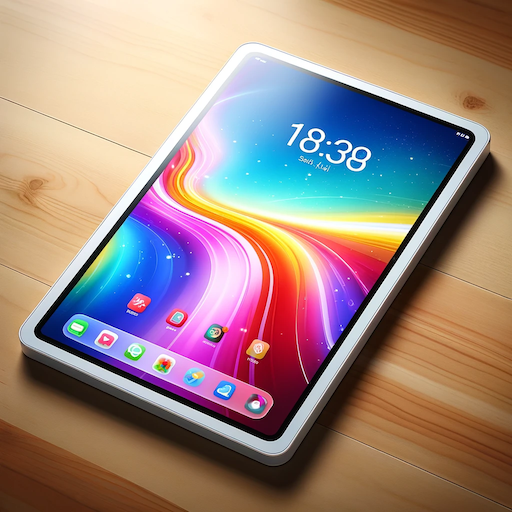

In [96]:
rgb_image

In [97]:
from torchvision import transforms
convert_tensor = transforms.ToTensor()
sample_tablet_tensor = convert_tensor(rgb_image).half().to("cuda")


sample_tablet_tensor.shape

torch.Size([3, 512, 512])

In [98]:
vae = vae.to("cuda")
unet = unet.to("cuda")

In [99]:
vae.encode

<bound method AutoencoderKL.encode of AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 256, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
            (conv_shortcut): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
          )
          (1): ResnetBlock2D(
            (norm1): GroupNorm(32, 256, eps=1e-06, affine=True)
            (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 256, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (2): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 256, eps=1e-06, affine=True)
            (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 512, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
            (conv_shortcut): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
          )
          (1): ResnetBlock2D(
            (norm1): GroupNorm(32, 512, eps=1e-06, affine=True)
            (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 512, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (3): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 512, eps=1e-06, affine=True)
            (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 512, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
      )
    )
    (mid_block): UNetMidBlock2D(
      (attentions): ModuleList(
        (0): Attention(
          (group_norm): GroupNorm(32, 512, eps=1e-06, affine=True)
          (to_q): Linear(in_features=512, out_features=512, bias

In [100]:
latent = vae.encode(sample_tablet_tensor.unsqueeze(0))

In [101]:
latent

AutoencoderKLOutput(latent_dist=<diffusers.models.autoencoders.vae.DiagonalGaussianDistribution object at 0x7cdf701a8e20>)

In [102]:
latents = latent.latent_dist.mean

In [103]:
latents.shape

torch.Size([1, 4, 64, 64])

In [104]:
prompts = ["A photo of a laptop on a table"]

In [105]:
mk_samples(prompts, latents)

  0%|          | 0/70 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (154x768 and 1024x320)